### Business Understanding

Stakeholder: Customer Retention Department of a Telecommunications Provider.

Business Problem: The telecommunications industry faces high competition, making customer retention a critical priority. Acquiring a new customer is significantly more expensive than retaining an existing one. High churn rates (the rate at which customers leave the service) directly impact revenue and market share.

Objectives:

Identify the key drivers behind customer churn.

Develop a predictive model to flag customers with a high probability of churning.

Provide actionable recommendations to reduce churn based on model insights.

### Data understanding
The dataset contains 3,333 records and 21 columns, covering customer account information, usage statistics, and customer service interactions.

#### Key Observations

- **Target Variable (churn):** Approximately 14.5% of customers in the dataset have churned. This indicates a class imbalance, which must be addressed during modeling and evaluation.
- **Customer Service Calls:** There is a visible trend where customers who churn have a higher average number of customer service calls, suggesting dissatisfaction.
- **International Plan:** Customers with an international plan appear to have a higher churn rate compared to those without one.
- **Usage Features:** Columns for "Day", "Evening", "Night", and "International" minutes and charges are provided. Preliminary correlation analysis showed that "Minutes" and "Charge" are perfectly correlated ($r = 1.0$), as the charge is a linear function of minutes.


#### Data Preparation

#### Feature Selection
- Dropped phone number as it is a unique identifier with no predictive power.
- Dropped state and area code to simplify the initial model (can be revisited later).
- Dropped total day charge, total eve charge, total night charge, and total intl charge to prevent multicollinearity with the "minutes" features.

#### Encoding
- Mapped international plan and voice mail plan from "yes"/"no" to binary $1/0$.
- Converted the target churn to integer format ($1$ for True, $0$ for False).

#### Train-Test Split
- The data was split into 80% Training and 20% Testing sets.
- Used stratified sampling to ensure the churn distribution remained consistent across both sets.

#### Scaling
- Applied StandardScaler to the training features to normalize numerical values (essential for distance-based models like Logistic Regression).
- The transformation was then applied to the test set using the training parameters to prevent data leakage.

In [1024]:
### import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso , LogisticRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [1025]:
df = pd.read_csv('ChurnInTelecom.csv')
df.head(10)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,...,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,...,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,...,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


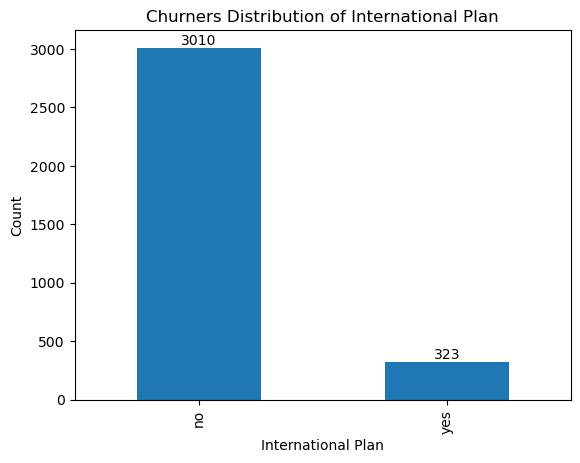

In [1026]:
import matplotlib.pyplot as plt

ax = df['international plan'].value_counts().plot(kind='bar')
plt.Figure(figsize=(10,8))
plt.ylabel("Count")
plt.xlabel("International Plan")
plt.title("Churners Distribution of International Plan")

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()


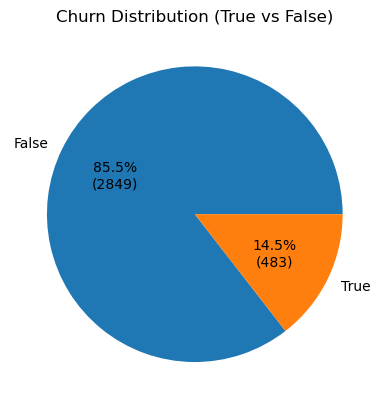

In [1027]:
import matplotlib.pyplot as plt

churn_tf = df['churn'].replace({'Yes': True, 'No': False})
churn_counts = churn_tf.value_counts()

plt.Figure(figsize=(10,8))
plt.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(p * sum(churn_counts) / 100)})'
)

plt.title("Churn Distribution (True vs False)")
plt.show()

**Churn vs. Intl Plan:** Revealed that international plan subscribers are disproportionately represented among churners.


In [1028]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate averages
avg_day_calls = df['total day calls'].mean()
avg_eve_calls = df['total eve calls'].mean()

avg_day_minutes = df['total day minutes'].mean()
avg_eve_minutes = df['total eve minutes'].mean()

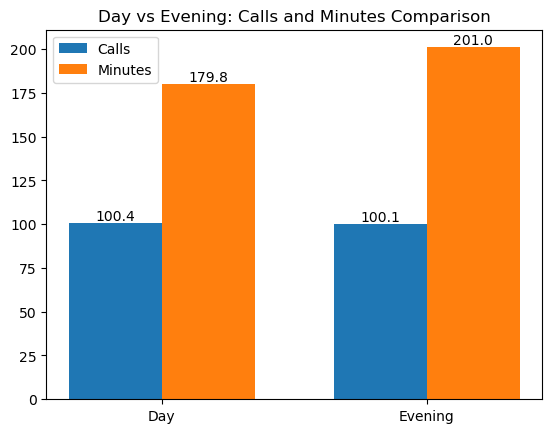

In [1029]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Day', 'Evening']

calls = [avg_day_calls, avg_eve_calls]
minutes = [avg_day_minutes, avg_eve_minutes]

x = np.arange(len(labels))
width = 0.35

plt.Figure(figsize=(10,8))

bars1 = plt.bar(x - width/2, calls, width, label='Calls')
bars2 = plt.bar(x + width/2, minutes, width, label='Minutes')

plt.xticks(x, labels)
plt.title("Day vs Evening: Calls and Minutes Comparison")
plt.legend()

# Add values on top of bars
for bar in bars1:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{bar.get_height():.1f}',
        ha='center',
        va='bottom'
    )

for bar in bars2:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{bar.get_height():.1f}',
        ha='center',
        va='bottom'
    )

plt.show()


#### Customers spend more time per call in the evening than day implying that evening conversations are longer on average.

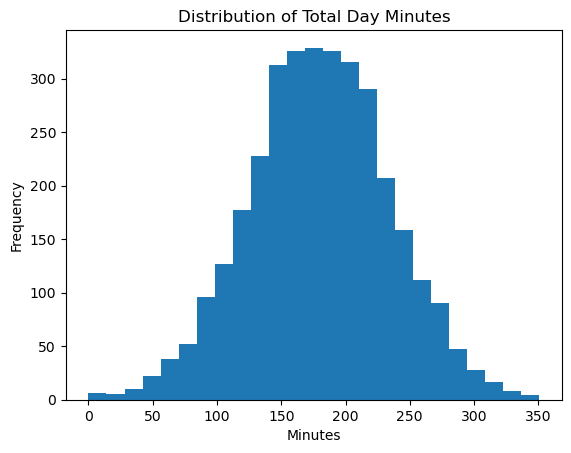

In [1030]:
#Distribution of total day minutes
plt.Figure(figsize=(10,8))
plt.hist(df['total day minutes'], bins=25)
plt.title("Distribution of Total Day Minutes")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

<Figure size 2000x1600 with 0 Axes>

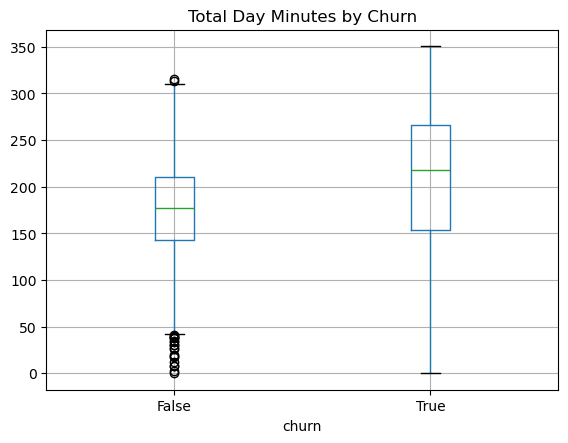

In [1031]:
plt.figure(figsize=(20,16))
df.boxplot(column='total day minutes', by='churn')
plt.title("Total Day Minutes by Churn")
plt.suptitle("")
plt.show()

In [1032]:
import numpy as np
import matplotlib.pyplot as plt

# Average minutes
avg_minutes = [
    df['total day minutes'].mean(),
    df['total eve minutes'].mean(),
    df['total night minutes'].mean(),
    df['total intl minutes'].mean()
]

# Average charges
avg_charges = [
    df['total day charge'].mean(),
    df['total eve charge'].mean(),
    df['total night charge'].mean(),
    df['total intl charge'].mean()
]

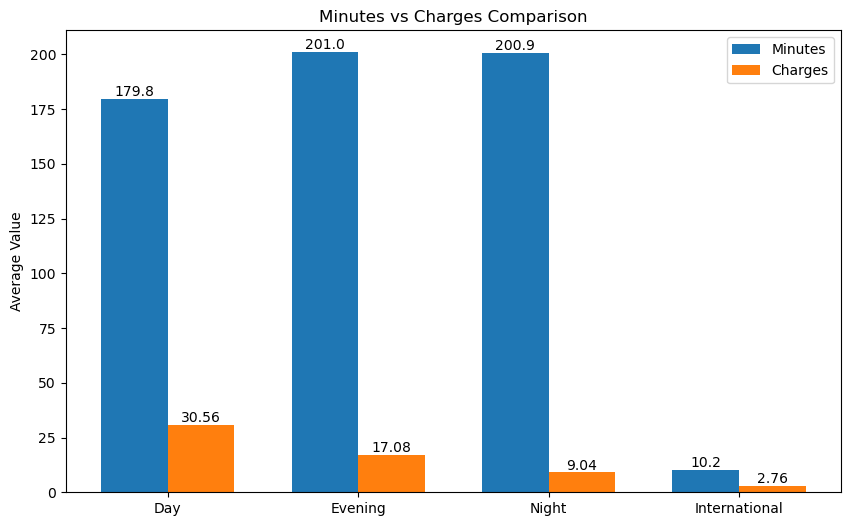

In [1033]:
labels = ['Day', 'Evening', 'Night', 'International']

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - width/2, avg_minutes, width, label='Minutes')
bars2 = plt.bar(x + width/2, avg_charges, width, label='Charges')

plt.xticks(x, labels)
plt.title("Minutes vs Charges Comparison")
plt.ylabel("Average Value")
plt.legend()

# Add values on bars
for bar in bars1:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{bar.get_height():.1f}',
        ha='center',
        va='bottom'
    )

for bar in bars2:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{bar.get_height():.2f}',
        ha='center',
        va='bottom'
    )

plt.show()


In [1034]:
df[['total day minutes', 'total day charge',
    'total eve minutes', 'total eve charge',
    'total night minutes', 'total night charge',
    'total intl minutes', 'total intl charge']].corr()

,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl charge
total day minutes,1.000000,1.000000,0.007043,0.007029,0.004323,0.004300,-0.010155,-0.010092
total day charge,1.000000,1.000000,0.007050,0.007036,0.004324,0.004301,-0.010157,-0.010094
total eve minutes,0.007043,0.007050,1.000000,1.000000,-0.012584,-0.012593,-0.011035,-0.011067
total eve charge,0.007029,0.007036,1.000000,1.000000,-0.012592,-0.012601,-0.011043,-0.011074
total night minutes,0.004323,0.004324,-0.012584,-0.012592,1.000000,0.999999,-0.015207,-0.015180
total night charge,0.004300,0.004301,-0.012593,-0.012601,0.999999,1.000000,-0.015214,-0.015186
total intl minutes,-0.010155,-0.010157,-0.011035,-0.011043,-0.015207,-0.015214,1.000000,0.999993
total intl charge,-0.010092,-0.010094,-0.011067,-0.011074,-0.015180,-0.015186,0.999993,1.000000


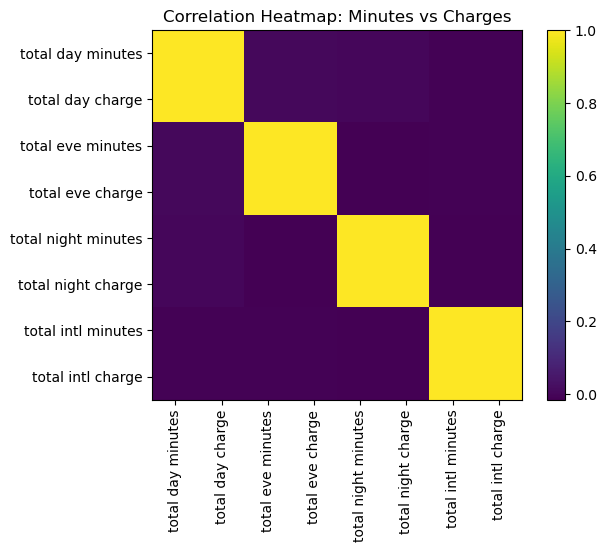

In [1035]:
import matplotlib.pyplot as plt
import numpy as np

# Select relevant columns
cols = [
    'total day minutes', 'total day charge',
    'total eve minutes', 'total eve charge',
    'total night minutes', 'total night charge',
    'total intl minutes', 'total intl charge'
]

# Compute correlation matrix
corr_matrix = df[cols].corr()

# Plot heatmap
plt.figure()

plt.imshow(corr_matrix)

plt.colorbar()

plt.xticks(np.arange(len(cols)), cols, rotation=90)
plt.yticks(np.arange(len(cols)), cols)

plt.title("Correlation Heatmap: Minutes vs Charges")

plt.show()


In [1036]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [1037]:
df.shape

(3333, 21)

In [1038]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [1039]:
df.duplicated().sum()

0

In [1040]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [1041]:
df['state'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

In [1042]:
df['churn'].unique()

array([False,  True])

In [1043]:
df['churn'].value_counts()

churn
False    2850
True      483
Name: count, dtype: int64

In [1044]:
print(f'True:', (483/3333)*100)
print(f'False:', (2850/3333)*100)


True: 14.491449144914492
False: 85.5085508550855


In [1045]:
df = df.drop(['phone number'], axis=1)

In [1046]:
df2 = df.copy()

#### Convert the categorical values into numeric labels across the dataset, loop through every column and display the dataframe

In [1047]:
encoder = LabelEncoder()

for col in df2.columns:
    df2[col] = encoder.fit_transform(df2[col])
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   state                   3333 non-null   int32
 1   account length          3333 non-null   int64
 2   area code               3333 non-null   int64
 3   international plan      3333 non-null   int32
 4   voice mail plan         3333 non-null   int32
 5   number vmail messages   3333 non-null   int64
 6   total day minutes       3333 non-null   int64
 7   total day calls         3333 non-null   int64
 8   total day charge        3333 non-null   int64
 9   total eve minutes       3333 non-null   int64
 10  total eve calls         3333 non-null   int64
 11  total eve charge        3333 non-null   int64
 12  total night minutes     3333 non-null   int64
 13  total night calls       3333 non-null   int64
 14  total night charge      3333 non-null   int64
 15  total intl minutes   

In [1048]:
df2.shape

(3333, 20)

In [1049]:
df2.columns

Index(['state', 'account length', 'area code', 'international plan',
       'voice mail plan', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls',
       'churn'],
      dtype='object')

In [1050]:
df2

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,126,1,0,1,19,1491,70,1491,767,60,684,1184,49,657,79,3,79,1,0
1,35,105,1,0,1,20,667,83,667,748,64,668,1265,61,701,116,3,116,1,0
2,31,135,1,0,0,0,1362,74,1362,158,71,150,443,62,292,101,5,101,0,0
3,35,82,0,1,0,0,1625,31,1625,13,49,13,758,47,445,45,7,45,2,0
4,36,73,1,1,0,0,711,73,711,330,83,307,664,79,401,80,3,80,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,3,189,1,0,1,30,618,37,618,934,87,829,1433,41,801,78,6,78,2,0
3329,49,66,1,0,0,0,1269,17,1269,375,16,349,705,81,420,75,4,75,3,0
3330,39,26,2,0,0,0,833,69,833,1489,19,1322,711,49,423,120,6,120,2,0
3331,6,182,2,1,0,0,1123,65,1123,427,45,394,266,95,191,29,10,29,2,0


In [1051]:
df2.corr()['churn']

state                     0.007780
account length            0.016290
area code                 0.003256
international plan        0.259852
voice mail plan          -0.102148
number vmail messages    -0.085624
total day minutes         0.187623
total day calls           0.019764
total day charge          0.187623
total eve minutes         0.090260
total eve calls           0.008519
total eve charge          0.090443
total night minutes       0.036105
total night calls         0.006120
total night charge        0.036595
total intl minutes        0.066960
total intl calls         -0.052844
total intl charge         0.066960
customer service calls    0.208750
churn                     1.000000
Name: churn, dtype: float64

#### drop phone number

In [1052]:
# df2 = df2.drop('phone number', axis=1)
df2.describe()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,26.059406,99.005101,1.000600,0.096910,0.276628,6.440144,826.339634,60.467447,826.339634,801.292529,61.132613,715.447645,793.796580,58.109511,463.044404,81.478548,4.479448,81.478548,1.562856,0.144914
std,14.824911,39.589501,0.709649,0.295879,0.447398,11.146322,417.413913,19.893502,417.413913,403.148568,19.806578,352.373293,399.771092,19.515154,209.589781,27.420275,2.461214,27.420275,1.315491,0.352067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,72.000000,0.000000,0.000000,0.000000,0.000000,508.000000,47.000000,508.000000,489.000000,48.000000,447.000000,484.000000,45.000000,312.000000,64.000000,3.000000,64.000000,1.000000,0.000000
50%,26.000000,99.000000,1.000000,0.000000,0.000000,0.000000,820.000000,61.000000,820.000000,804.000000,61.000000,717.000000,795.000000,58.000000,462.000000,82.000000,4.000000,82.000000,1.000000,0.000000
75%,39.000000,125.000000,2.000000,0.000000,1.000000,14.000000,1146.000000,74.000000,1146.000000,1111.000000,75.000000,982.000000,1103.000000,71.000000,616.000000,100.000000,6.000000,100.000000,2.000000,0.000000
max,50.000000,211.000000,2.000000,1.000000,1.000000,45.000000,1666.000000,118.000000,1666.000000,1610.000000,122.000000,1439.000000,1590.000000,119.000000,932.000000,161.000000,20.000000,161.000000,9.000000,1.000000


#### Data scaling

In [1053]:
scaler = StandardScaler()

cols_to_scale = ['state', 'account length', 'international plan', 'voice mail plan', 'number vmail messages',
                 'total day minutes', 'total day calls', 'total eve minutes', 'total eve calls',
                 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls',
                 'customer service calls']

X = df2[cols_to_scale]
y = df2['churn'] 

df2[cols_to_scale] = scaler.fit_transform(X)

df2.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,-0.678649,0.681972,1,-0.327580,1.617086,1.126985,1.592568,0.479251,1491,-0.085075,-0.057192,684,0.976214,-0.466862,657,-0.090405,-0.601195,79,-0.427932,0
1,0.603170,0.151449,1,-0.327580,1.617086,1.216714,-0.381788,1.132829,667,-0.132211,0.144791,668,1.178860,0.148137,701,1.259164,-0.601195,116,-0.427932,0
2,0.333313,0.909340,1,-0.327580,-0.618396,-0.577869,1.283476,0.680352,1362,-1.595911,0.498262,150,-0.877625,0.199387,292,0.712042,0.211534,101,-1.188218,0
3,0.603170,-0.429600,0,3.052685,-0.618396,-0.577869,1.913641,-1.481482,1625,-1.955633,-0.612647,13,-0.089556,-0.569362,445,-1.330549,1.024263,45,0.332354,0
4,0.670634,-0.656967,1,3.052685,-0.618396,-0.577869,-0.276361,0.630077,711,-1.169205,1.104212,307,-0.324726,1.070636,401,-0.053930,-0.601195,80,1.092641,0


In [1054]:
import pandas as pd

df_combined = pd.concat([X, y], axis=1)
df_combined.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,16,126,0,1,19,1491,70,767,60,1184,49,79,3,1,0
1,35,105,0,1,20,667,83,748,64,1265,61,116,3,1,0
2,31,135,0,0,0,1362,74,158,71,443,62,101,5,0,0
3,35,82,1,0,0,1625,31,13,49,758,47,45,7,2,0
4,36,73,1,0,0,711,73,330,83,664,79,80,3,3,0


In [1055]:
df_combined.describe()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,26.059406,99.005101,0.096910,0.276628,6.440144,826.339634,60.467447,801.292529,61.132613,793.796580,58.109511,81.478548,4.479448,1.562856,0.144914
std,14.824911,39.589501,0.295879,0.447398,11.146322,417.413913,19.893502,403.148568,19.806578,399.771092,19.515154,27.420275,2.461214,1.315491,0.352067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,72.000000,0.000000,0.000000,0.000000,508.000000,47.000000,489.000000,48.000000,484.000000,45.000000,64.000000,3.000000,1.000000,0.000000
50%,26.000000,99.000000,0.000000,0.000000,0.000000,820.000000,61.000000,804.000000,61.000000,795.000000,58.000000,82.000000,4.000000,1.000000,0.000000
75%,39.000000,125.000000,0.000000,1.000000,14.000000,1146.000000,74.000000,1111.000000,75.000000,1103.000000,71.000000,100.000000,6.000000,2.000000,0.000000
max,50.000000,211.000000,1.000000,1.000000,45.000000,1666.000000,118.000000,1610.000000,122.000000,1590.000000,119.000000,161.000000,20.000000,9.000000,1.000000


In [1056]:
df_combined.corr()['churn']

state                     0.007780
account length            0.016290
international plan        0.259852
voice mail plan          -0.102148
number vmail messages    -0.085624
total day minutes         0.187623
total day calls           0.019764
total eve minutes         0.090260
total eve calls           0.008519
total night minutes       0.036105
total night calls         0.006120
total intl minutes        0.066960
total intl calls         -0.052844
customer service calls    0.208750
churn                     1.000000
Name: churn, dtype: float64

#### Fit the model

In [1057]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

In [1058]:
X_train.shape

(1666, 14)

In [1059]:
X_test.shape

(1667, 14)

In [1060]:
y_train.shape

(1666,)

In [1061]:
y_test.shape

(1667,)

### fitting our model

In [1062]:
LogR = LogisticRegression(max_iter=1000)
LogR.fit(X_train,y_train)

c:\Users\geoff\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [1063]:
y_pred = LogR.predict(X_test)

#### Accuracy score

In [1064]:
from sklearn.metrics import accuracy_score, confusion_matrix, auc
accuracy_on_churn = accuracy_score(y_test,y_pred)

print(f'Accurancy score of the model fitted:{accuracy_on_churn:.3f} ({accuracy_on_churn*100:.1f}%)')

Accurancy score of the model fitted:0.863 (86.3%)


#### Evaluate the model

In [1065]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Detailed Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1425
           1       0.57      0.21      0.31       242

    accuracy                           0.86      1667
   macro avg       0.73      0.59      0.62      1667
weighted avg       0.83      0.86      0.83      1667




Confusion Matrix:


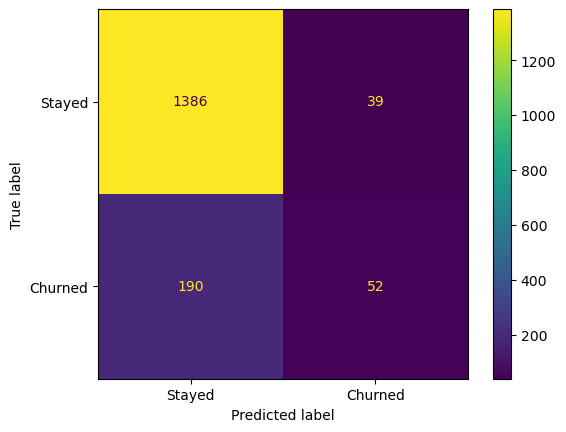

In [1066]:
# Visual Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Churned'])
disp.plot()
plt.show()

1. True Negatives (TN)
These are customers the model correctly predicted would stay. This is usually the largest number because most people don't churn.

2. False Positives (FP) — "The False Alarm"
The model predicted they would churn, but they actually stayed.

Business Impact: You might waste money giving these people "loyalty discounts" or special offers they didn't actually need to stay.

3. False Negatives (FN) — "The Silent Exit"
The model predicted they would stay, but they actually churned.

Business Impact: This is the most "expensive" error. You missed the chance to intervene, and you've now lost the customer's lifetime value.

4. True Positives (TP) — "The Success"
The model correctly identified people who were going to leave.

Business Impact: These are the people your marketing team should target immediately with retention campaigns.

The Decision: Precision vs. Recall
The reason we look at this matrix is to decide which error is worse for your specific business:

If you want to catch every single churner: You want high Recall. You are willing to accept more False Positives (giving out more discounts) to ensure you don't miss any True Positives.

If you have a limited budget for retention: You want high Precision. You only want to target people you are very sure are going to leave so you don't waste money.

In [1067]:
# from sklearn.linear_model import Ridge

rg = Ridge(alpha=1.0)

rg.fit(X_train, y_train)

y_pred = rg.predict(X_test)

#### to check lengths

In [1068]:
print(len(X_train))
print(len(y_train))
print(len(y))

1666
1666
3333


#### Lasso regression


In [1069]:
from sklearn.linear_model import Lasso

# Create model
lasso = Lasso(alpha=1.0)

# Fit using TRAIN data
lasso.fit(X_train, y_train)

# Predict using TEST data
y_pred_lasso = lasso.predict(X_test)

In [1070]:
# Evaluate Model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred_lasso)
r2 = r2_score(y_test, y_pred_lasso)

print("MSE:", mse)
print("R2 Score:", r2)

MSE: 0.11745199971281811
R2 Score: 0.05354191668855035


In [1071]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

lasso_model = make_pipeline(
    StandardScaler(),
    Lasso(alpha=1.0)
)

lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)


#### Check removed features

In [1072]:
import pandas as pd

coefficients = pd.Series(lasso.coef_, index=X_train.columns)

print(coefficients)
print("\nFeatures eliminated (coefficient = 0):")
print(coefficients[coefficients == 0])


state                    -0.000000
account length            0.000000
international plan        0.000000
voice mail plan          -0.000000
number vmail messages    -0.000000
total day minutes         0.000120
total day calls           0.000000
total eve minutes         0.000075
total eve calls           0.000000
total night minutes       0.000024
total night calls        -0.000000
total intl minutes        0.000000
total intl calls         -0.000000
customer service calls    0.000000
dtype: float64

Features eliminated (coefficient = 0):
state                    -0.0
account length            0.0
international plan        0.0
voice mail plan          -0.0
number vmail messages    -0.0
total day calls           0.0
total eve calls           0.0
total night calls        -0.0
total intl minutes        0.0
total intl calls         -0.0
customer service calls    0.0
dtype: float64


#### Decision Tree

In [1073]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

#use for loop to encode our categorical to numeric
for col in df2.columns:
  df2[col] = encoder.fit_transform(df2[col])

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   state                   3333 non-null   int64
 1   account length          3333 non-null   int64
 2   area code               3333 non-null   int64
 3   international plan      3333 non-null   int64
 4   voice mail plan         3333 non-null   int64
 5   number vmail messages   3333 non-null   int64
 6   total day minutes       3333 non-null   int64
 7   total day calls         3333 non-null   int64
 8   total day charge        3333 non-null   int64
 9   total eve minutes       3333 non-null   int64
 10  total eve calls         3333 non-null   int64
 11  total eve charge        3333 non-null   int64
 12  total night minutes     3333 non-null   int64
 13  total night calls       3333 non-null   int64
 14  total night charge      3333 non-null   int64
 15  total intl minutes   

In [1074]:
X = df2.drop(['churn'], axis=1)
y = df2['churn']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=254, test_size=0.7)

In [1075]:
#instantiate

dt = DecisionTreeClassifier(random_state=254)

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=254)

In [1076]:
from sklearn.metrics import accuracy_score, roc_curve , RocCurveDisplay, auc

#predictions

y_preds = dt.predict(X_test)

accuracy_score(y_test, y_preds)

print(f'Accurancy score of the model fitted:{accuracy_score(y_test, y_preds):.3f} ({accuracy_score(y_test, y_preds)*100:.1f}%)')

Accurancy score of the model fitted:0.910 (91.0%)


In [1077]:
dt.predict_proba(X_test)[:, 1]

array([0., 0., 0., ..., 0., 0., 1.])

In [1078]:
##probability for the linear regression model
lr_y_prob = lr.predict_proba(X_test)[:, 1]

dt_y_prob =  dt.predict_proba(X_test)[:, 1]

lr_fpr, lr_tpr, i = roc_curve(y_test, lr_y_prob)

dt_fpr, dt_tpr, i = roc_curve(y_test, dt_y_prob)

lr_auc = auc(lr_fpr, lr_tpr)
dt_auc = auc(dt_fpr, dt_tpr)

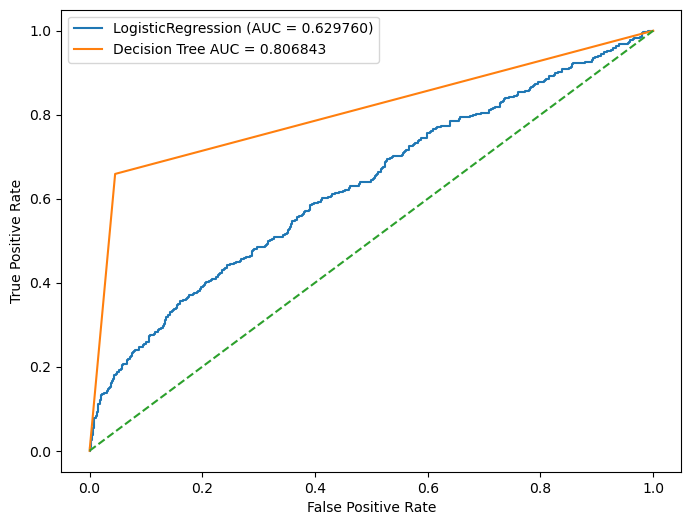

In [1079]:
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'LogisticRegression (AUC = {lr_auc:2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree AUC = {dt_auc:2f}')
plt.plot([0,1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()